In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cavidannuriyev","key":"0e7d9b903fbfb17026c86180e4709dfa"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d lakshaymiddha/crack-segmentation-dataset

Dataset URL: https://www.kaggle.com/datasets/lakshaymiddha/crack-segmentation-dataset
License(s): unknown


In [ ]:
!unzip /content/crack-segmentation-dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2827_1672_43_3463_3133.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2827_1769_76_2872_3754.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2827_2156_467_3481_3232.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2827_2215_554_3226_3035.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2827_2427_389_2516_2743.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2827_2998_282_2659_3414.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2827_315_10_3098_3166.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2827_369_583_3066_3082.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_fo

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!wget https://raw.githubusercontent.com/databyhuseyn/DeepLearning/refs/heads/main/helper_functions.py

--2025-04-18 10:08:32--  https://raw.githubusercontent.com/databyhuseyn/DeepLearning/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-04-18 10:08:32 (15.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import plot_loss_curves

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
import os

In [ ]:
train_image_dir = '/content/crack_segmentation_dataset/train/images'
train_mask_dir = '/content/crack_segmentation_dataset/train/masks'
test_image_dir = '/content/crack_segmentation_dataset/test/images'
test_mask_dir = '/content/crack_segmentation_dataset/test/masks'

In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 8

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
def load_data(image_dir, mask_dir, img_size):
    images, masks = [], []

    # Loop over images and masks
    for filename in os.listdir(image_dir):
        # Load image
        img = load_img(os.path.join(image_dir, filename), target_size=img_size)
        img = img_to_array(img) / 255.0  # Normalize to [0,1]
        images.append(img)

        # Load corresponding mask
        mask = load_img(os.path.join(mask_dir, filename), target_size=img_size, color_mode="grayscale")
        mask = img_to_array(mask) / 255.0  # Normalize to [0,1]
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load train and test data
X_train, y_train = load_data(
    train_image_dir,
    train_mask_dir,
    IMG_SIZE
)

X_test, y_test = load_data(
    test_image_dir,
    test_mask_dir,
    IMG_SIZE
)

In [ ]:
def augment_image_and_mask(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.rot90(image)
        mask = tf.image.rot90(mask)
    return image, mask

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(lambda x, y: augment_image_and_mask(x, y), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(100).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)


In [ ]:
print(f'Train images shape: {X_train.shape}, Train masks shape: {y_train.shape}')
print(f'Test images shape: {X_test.shape}, Test masks shape: {y_test.shape}')

Train images shape: (9603, 128, 128, 3), Train masks shape: (9603, 128, 128, 1)
Test images shape: (1695, 128, 128, 3), Test masks shape: (1695, 128, 128, 1)


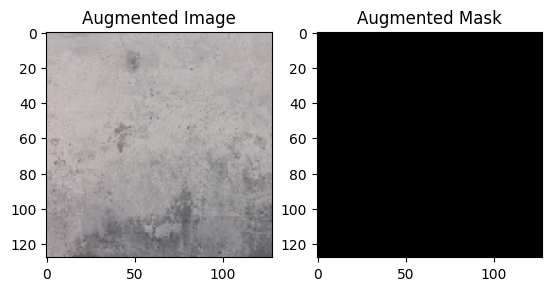

In [ ]:
for image, mask in train_dataset.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(image[0])
    plt.title("Augmented Image")

    plt.subplot(1, 2, 2)
    plt.imshow(tf.squeeze(mask[0]), cmap='gray')
    plt.title("Augmented Mask")
    plt.show()

In [ ]:
input_shape=(256, 256, 3)

In [ ]:
inputs = tf.keras.layers.Input(shape=input_shape)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
input_layer = tf.keras.Input(shape=(128, 128, 3))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

outputs = tf.keras.layers.Conv2D(filters=1, kernel_size =(1,1), activation = 'sigmoid')(x)

In [ ]:
model = models.Model(inputs=input_layer, outputs=outputs)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,537 (724.75 KB)

 Trainable params: 185,537 (724.75 KB)

 Non-trainable params: 0 (0.00 B)

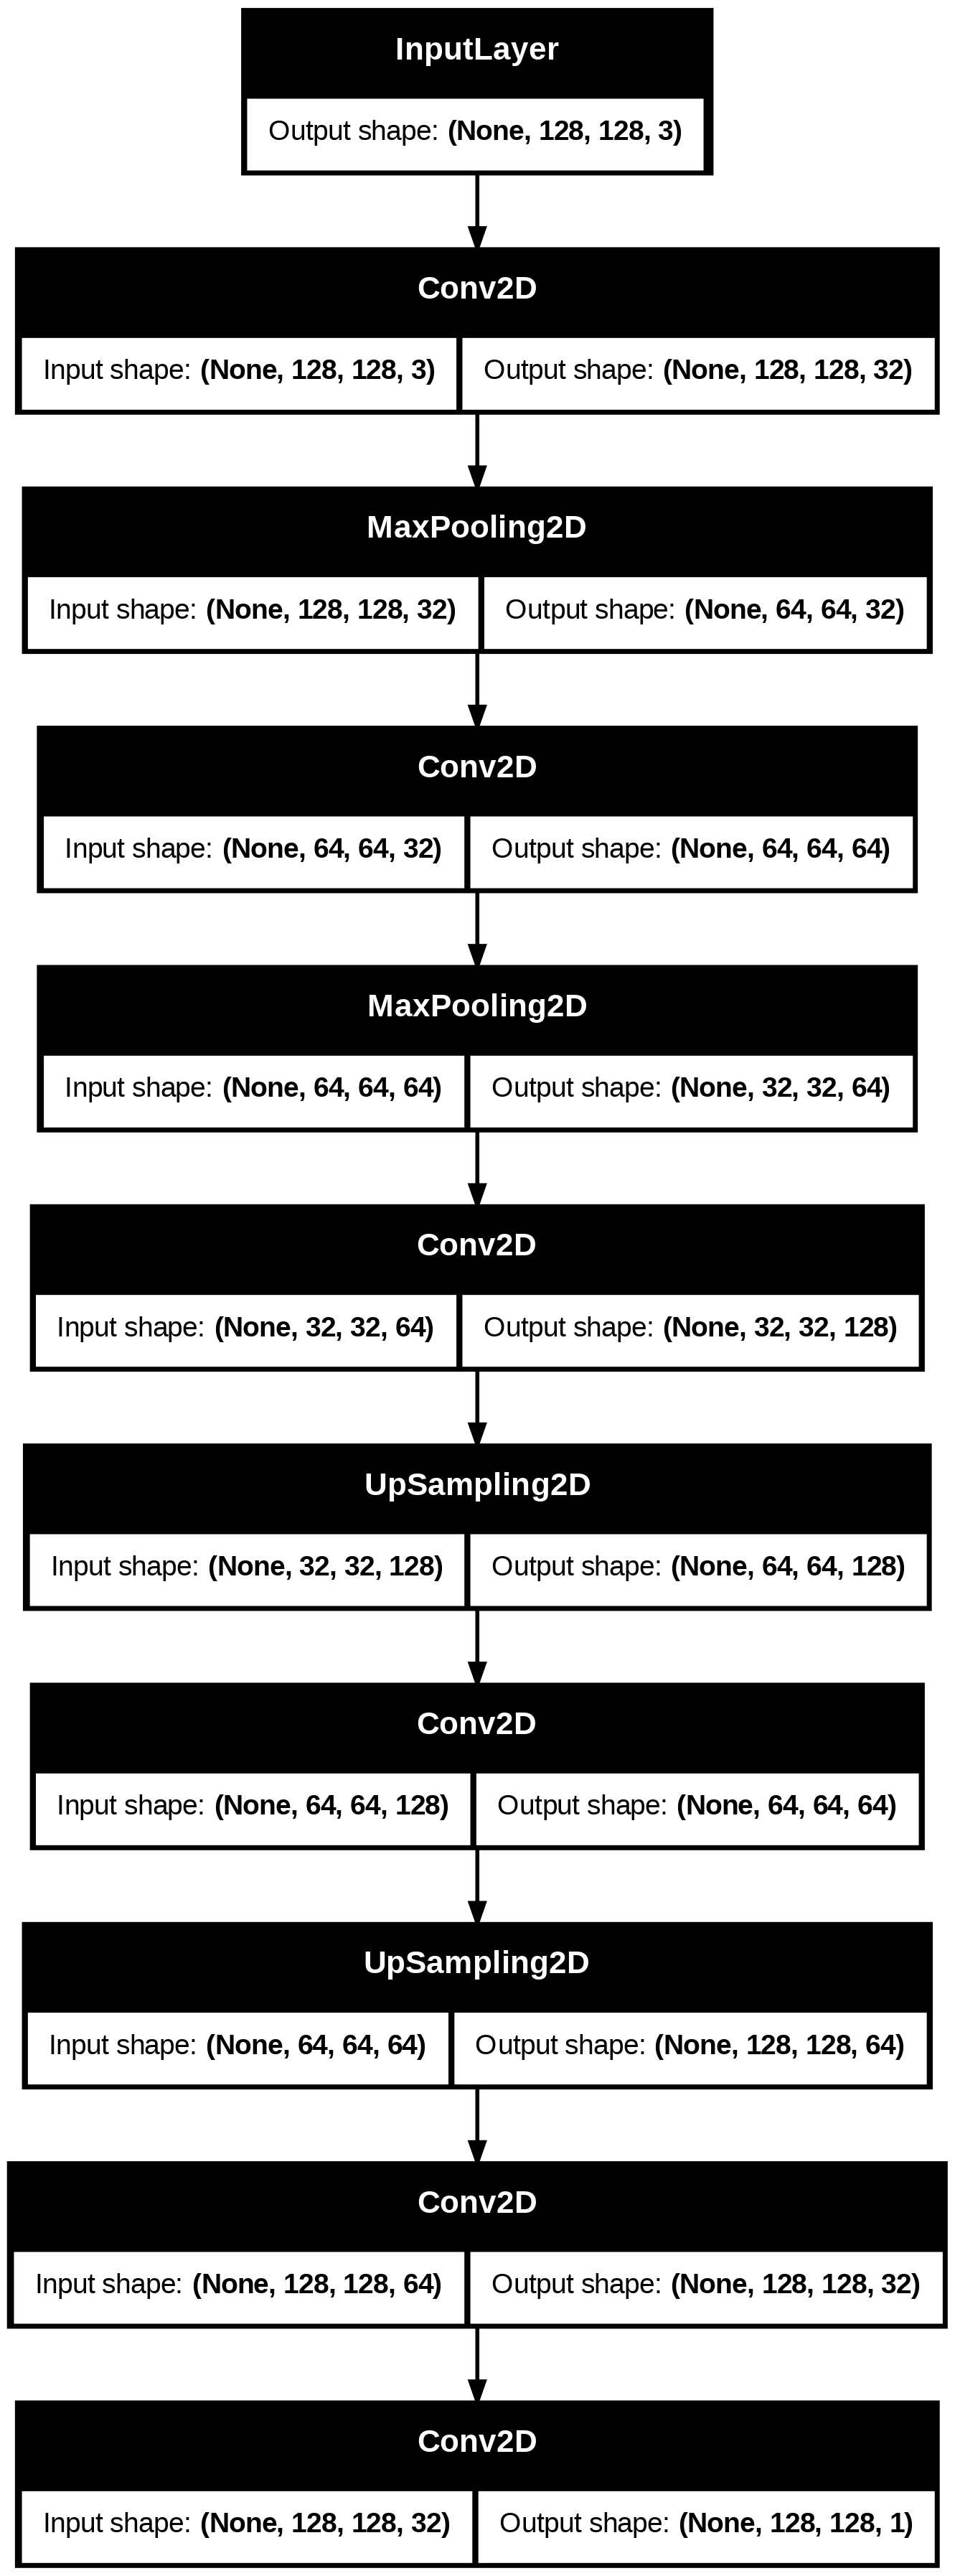

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model_ckp = tf.keras.callbacks.ModelCheckpoint('/content/best_model.weights.h5',
                                               save_best_only = True,
                                               save_weights_only = True)
early_stopping = tf.keras.callbacks.EarlyStopping(restore_best_weights = True,
                                                  patience = 3)

model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics = ['accuracy'])


In [ ]:
history = model.fit(train_dataset,
                    epochs = 10,
                    validation_data = test_dataset,
                    callbacks = [model_ckp, early_stopping])

Epoch 1/10
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9593 - loss: 0.1398 - val_accuracy: 0.9626 - val_loss: 0.0952
Epoch 2/10
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9634 - loss: 0.0926 - val_accuracy: 0.9646 - val_loss: 0.0845
Epoch 3/10
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9649 - loss: 0.0847 - val_accuracy: 0.9654 - val_loss: 0.0835
Epoch 4/10
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9656 - loss: 0.0812 - val_accuracy: 0.9659 - val_loss: 0.0783
Epoch 5/10
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9661 - loss: 0.0781 - val_accuracy: 0.9660 - val_loss: 0.0788
Epoch 6/10
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9662 - loss: 0.0771 - val_accuracy: 0.9653 - val_loss: 0.0778
Epoch 7/10
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9663 - loss: 0.0771 - val_accuracy: 0.9669 - val_loss: 0.0743
Epoch 8/10
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9665 -

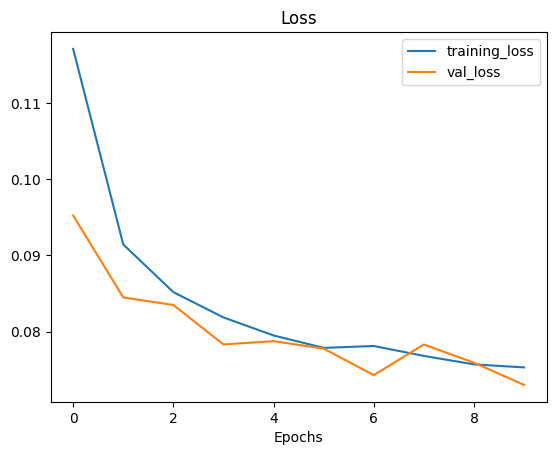

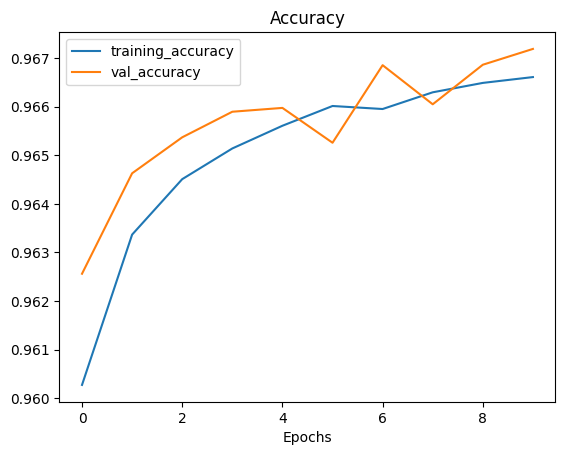

In [ ]:
plot_loss_curves(history)

In [ ]:
img_path = '/content/cracked_concrete_2.jpg'
new_img = load_img(img_path, target_size=IMG_SIZE)
new_img = img_to_array(new_img) / 255.0  # Normalize to [0,1]

In [ ]:
pred = model(tf.expand_dims(new_img, axis=0))

In [ ]:
original_img = '/content/cracked_concrete_2.jpg'
or_img = plt.imread(original_img)
or_img = load_img(original_img, target_size=IMG_SIZE)
or_img = img_to_array(or_img) / 255.0

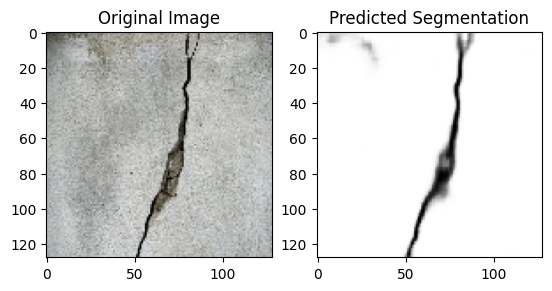

In [ ]:
plt.subplot(121)
plt.imshow(or_img)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(tf.squeeze(pred), cmap='binary')
plt.title('Predicted Segmentation')
plt.show()

In [ ]:
img_path_3 = '/content/cracked_concrete_3.jpg'
new_img_3 = load_img(img_path_3, target_size=IMG_SIZE)
new_img_3 = img_to_array(new_img_3) / 255.0  # Normalize to [0,1]

In [ ]:
pred_3 = model(tf.expand_dims(new_img_3, axis=0))

In [ ]:
original_img_3 = '/content/cracked_concrete_3.jpg'
or_img_3 = plt.imread(original_img_3)
or_img_3 = load_img(original_img_3, target_size=IMG_SIZE)
or_img_3 = img_to_array(or_img_3) / 255.0

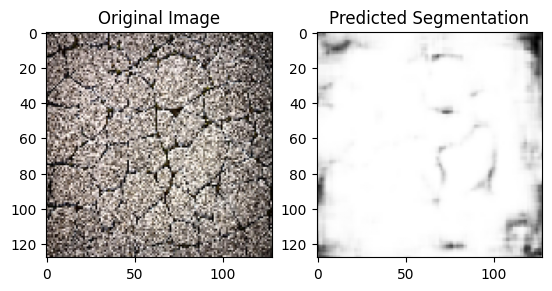

In [ ]:
plt.subplot(121)
plt.imshow(or_img_3)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(tf.squeeze(pred_3), cmap='binary')
plt.title('Predicted Segmentation')
plt.show()

In [ ]:
img_path_4 = '/content/cracked_concrete_4.jpeg'
new_img_4 = load_img(img_path_4, target_size=IMG_SIZE)
new_img_4 = img_to_array(new_img_4) / 255.0  # Normalize to [0,1]

In [ ]:
pred_4 = model(tf.expand_dims(new_img_4, axis=0))

In [ ]:
original_img_4 = '/content/cracked_concrete_4.jpeg'
or_img_4 = plt.imread(original_img_4)
or_img_4 = load_img(original_img_4, target_size=IMG_SIZE)
or_img_4 = img_to_array(or_img_4) / 255.0

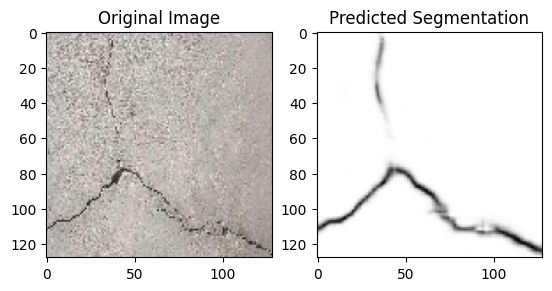

In [ ]:
plt.subplot(121)
plt.imshow(or_img_4)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(tf.squeeze(pred_4), cmap='binary')
plt.title('Predicted Segmentation')
plt.show()